## 1. 메인 데이터 소개
### 1.1 장소: 역삼동 전체
### 1.2 조사기간: 7일
### 1.3 데이터 내용: 직접 돌아다니면서 흡연 밀집구역의 위도와 경도를 체크
*흡연 밀집구역: 담배를 2명 이상 피우고 있거나, 담배꽁초가 5개 이상 버려져 있는 곳으로 정의*

## 2. EDA

### 2.1 메인 데이터 로드

In [1]:
import warnings
warnings.filterwarnings('ignore') # 경고메시지 무시
import numpy as np
import pandas as pd               # 판다스 라이브러리
import requests                   # 웹크롤링 라이브러리
import folium                     # 지도 시각화 라이브러리
!pip install haversine            
from haversine import haversine   # 위,경도로 거리구하는 함수
import matplotlib.pyplot as plt
import seaborn as sns             # 데이터 시각화 라이브러리

In [2]:
# 한글 폰트
# 윈도우 : "Malgun Gothic"
# 맥 : "AppleGothic"
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    # colab 사용자는 system_name이 'Linux'로 확인

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family


plt.style.use("seaborn-whitegrid")

# 폰트설정
plt.rc("font", family=get_font_family())
# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)

# 그래프에 retina display 적용
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("retina")

In [3]:
yssmoke_df = pd.read_csv('./역삼동_211228_최종.csv')
yssmoke_df

,no,lat,long
0,1,37.53269,127.03221
1,2,37.49942,127.03062
2,3,37.49954,127.03055
3,4,37.50508,127.02952
4,5,37.50601,127.02988
...,...,...,...
1517,1518,37.50644,127.03244
1518,1519,37.50639,127.03259
1519,1520,37.50583,127.03339
1520,1521,37.50494,127.03316


### 2.2 메인 데이터 전처리
#### 1) 가까운 지하철역과 그 거리 
흡연은 지하철 역과의 거리에서 관계가 있을 것이라는 판단이 들었다.  
따라서 모든 흡연 구역에서 가장 가까운 지하철역까지의 거리를 구하고 추가했다.

**역삼동에 있는 7개의 지하철 역 위도와 경도**  
신논현역: 37.504414284494466, 127.02452835469147  
언주역: 37.50732817943336, 127.0338786967778  
선정릉역:37.51029175566823, 127.04386669611159  
강남역: 37.49794193277907, 127.02766352921518  
역삼역: 37.50064875282058, 127.03640335082471  
선릉역: 37.504541382252114, 127.0490065400319  
한티역: 37.4962858031279, 127.05287572644622  

In [4]:
# 역 이름: 위,경도(튜플)를 딕셔너리 형태의 데이터로 저장한다.
station = {'신논현':(37.504414284494466, 127.02450352657017),
            '언주역': (37.507286636185505, 127.0338693115856),
            '선정릉역':(37.51029175566823, 127.04386669611159),
            '강남역': (37.49794193277907, 127.02766352921518),
            '역삼역': (37.50064875282058, 127.03640335082471),
            '선릉역': (37.504483924164205, 127.04895950143413),
            '한티역': (37.4962858031279, 127.05287572644622)}

In [5]:
# find_station이라는 함수를 정의한다.
# 매개변수로 구하려는 위치의 위,경도를 튜플 형식으로 넣는다.
def find_station(point):
    temp_list=[]                        # 각 역과의 거리를 담을 빈 리스트를 생성
    for i, val in enumerate(station):   # 7개 역과 모두 비교하기 위한 for문
        temp_list.append(haversine(point, station[val]))
                    # haversine()함수를 통해 입력된 위,경도로 거리를 구하고 리스트에 넣는다.
    distance = temp_list[0]             # 리스트의 첫번째 값(신논현역과의 거리)을 거리로 설정
    short_num = 0                       # 가장 짧은 역을 알려줄 인덱스 최초 설정

    for i in range(1,7):                # 0번을 제외한 6개의 데이터를 비교하기 위한 for문
        if temp_list[i] < distance:     # 설정된 거리보다 다른 역과의 거리가 더 짧으면
            distance = temp_list[i]     # 해당 역과의 거리를 가장 짧은 역으로 설정
            short_num = i               # 그 역의 인덱스를 저장
    return list(station.keys())[short_num], round(distance * 1000, 2)
                 # 딕셔너리에서 해당 인덱스 번호로 키 값을 불러 역 이름을 부르고, 그 거리를 반환 

In [6]:
# 데이터프레임에서 역 이름과 거리를 넣을 컬럼을 생성
yssmoke_df['station'] = ''
yssmoke_df['distance'] = 0.0
# find_station 함수를 통해 모든 위치 데이터를 for문으로 돌리면서 가까운 역과 그 거리를 부르고
# 데이터프레임에 새로운 컬럼에 저장한다.
for i in range(len(yssmoke_df)):
    temp_list = []
    temp_list = find_station((yssmoke_df.iloc[i][1],yssmoke_df.iloc[i][2]))
    yssmoke_df['station'][i] = temp_list[0]
    yssmoke_df['distance'][i] = temp_list[1]

In [7]:
# 거리를 범주화 하기 위한 컬럼, 초기값은 0으로 넣는다
yssmoke_df['distance_gubun'] = 0

In [8]:
# 범주화 하기 위한 기준은 50m이고, 기준에 맞게 데이터를 넣는다.
yssmoke_df['distance_gubun'].loc[yssmoke_df['distance'] < 50] = 0
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 50) & (yssmoke_df['distance'] < 100)] = 50
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 100) & (yssmoke_df['distance'] < 150)] = 100
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 150) & (yssmoke_df['distance'] < 200)] = 150
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 200) & (yssmoke_df['distance'] < 250)] = 200
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 250) & (yssmoke_df['distance'] < 300)] = 250
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 300) & (yssmoke_df['distance'] < 350)] = 300
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 350) & (yssmoke_df['distance'] < 400)] = 350
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 400) & (yssmoke_df['distance'] < 450)] = 400
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 450) & (yssmoke_df['distance'] < 500)] = 450
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 500) & (yssmoke_df['distance'] < 550)] = 500
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 550) & (yssmoke_df['distance'] < 600)] = 550
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 600) & (yssmoke_df['distance'] < 650)] = 600
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 650) & (yssmoke_df['distance'] < 700)] = 650
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 700) & (yssmoke_df['distance'] < 750)] = 700
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 750) & (yssmoke_df['distance'] < 800)] = 750
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 800) & (yssmoke_df['distance'] < 850)] = 800
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 850) & (yssmoke_df['distance'] < 900)] = 850
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 900) & (yssmoke_df['distance'] < 950)] = 900
yssmoke_df['distance_gubun'].loc[(yssmoke_df['distance'] >= 950) & (yssmoke_df['distance'] < 1000)] = 950
yssmoke_df['distance_gubun'].loc[yssmoke_df['distance'] >= 1000] = 1000
yssmoke_df

,no,lat,long,station,distance,distance_gubun
0,1,37.53269,127.03221,선정릉역,2694.40,1000
1,2,37.49942,127.03062,강남역,308.28,300
2,3,37.49954,127.03055,강남역,310.51,300
3,4,37.50508,127.02952,신논현,448.66,400
4,5,37.50601,127.02988,언주역,379.45,350
...,...,...,...,...,...,...
1517,1518,37.50644,127.03244,언주역,157.35,150
1518,1519,37.50639,127.03259,언주역,150.58,150
1519,1520,37.50583,127.03339,언주역,167.40,150
1520,1521,37.50494,127.03316,언주역,268.33,250


#### 2) 고도 
데이터를 수집하면서 고도가 높은 곳은 담배를 피는 곳이 적은 것 같은 느낌을 받았다.
그래서 의미가 있을 것 같아 해당 위치에 고도 데이터를 넣어보았다.

In [9]:
# 데이터프레임에 고도를 넣을 새로운 컬럼을 생성
yssmoke_df['altitude'] = 0.0
# for문으로 데이터프레임에서 위,경도를 순차적으로 부르고 구글 API를 통해 그 위치의 고도데이터를 불러 저장한다.
for (index, data) in yssmoke_df.iterrows():
    url = "https://maps.googleapis.com/maps/api/elevation/json?locations={}%2C{}&key=(개인 api 키)".format(data["lat"], data["long"])
    yssmoke_df["altitude"][index] = requests.post(url).json()["results"][0]["elevation"]
print("수집 완료")

수집 완료


In [10]:
# 정상적으로 들어갔다.
yssmoke_df.sample(5)

,no,lat,long,station,distance,distance_gubun,altitude
689,690,37.50615,127.03959,언주역,520.20,500,42.642967
987,988,37.50712,127.04546,선정릉역,379.65,350,25.746847
977,978,37.50588,127.04406,선릉역,459.22,450,31.257410
642,643,37.50645,127.03860,언주역,427.53,400,44.811607
13,14,37.50392,127.03169,언주역,420.83,400,50.254967


In [11]:
# 고도를 범주화 하기 위한 컬럼, 초기값은 0으로 넣는다
yssmoke_df['altitude_gubun'] = 0

In [12]:
# 범주화 하기 위한 기준은 Contour Map Creator에 등고선을 그릴 때 잡힌 기준 값으로 동일하게 잡았고,
# 이는 2.3.2)에 나오는 데이터에서 그 범주를 확인할 수 있다.
yssmoke_df['altitude_gubun'].loc[yssmoke_df['altitude'] < 18] = 10
yssmoke_df['altitude_gubun'].loc[(yssmoke_df['altitude'] >= 18) & (yssmoke_df['altitude'] < 25)] = 18
yssmoke_df['altitude_gubun'].loc[(yssmoke_df['altitude'] >= 25) & (yssmoke_df['altitude'] < 31)] = 25
yssmoke_df['altitude_gubun'].loc[(yssmoke_df['altitude'] >= 31) & (yssmoke_df['altitude'] < 40)] = 31
yssmoke_df['altitude_gubun'].loc[(yssmoke_df['altitude'] >= 37) & (yssmoke_df['altitude'] < 43)] = 37
yssmoke_df['altitude_gubun'].loc[(yssmoke_df['altitude'] >= 43) & (yssmoke_df['altitude'] < 50)] = 43
yssmoke_df['altitude_gubun'].loc[(yssmoke_df['altitude'] >= 50) & (yssmoke_df['altitude'] < 56)] = 50
yssmoke_df['altitude_gubun'].loc[yssmoke_df['altitude'] >= 56] = 56

yssmoke_df.sample(10)

,no,lat,long,station,distance,distance_gubun,altitude,altitude_gubun
1429,1430,37.50038,127.04313,역삼역,594.15,550,33.846165,31
94,95,37.50122,127.02689,강남역,370.84,350,18.914099,18
199,200,37.49830,127.03474,역삼역,299.57,250,25.876610,25
337,338,37.49674,127.03574,역삼역,438.56,400,29.183556,25
65,66,37.49964,127.02827,강남역,196.25,150,24.030848,18
786,787,37.50302,127.04031,역삼역,433.92,400,42.258465,37
867,868,37.50786,127.04192,선정릉역,320.31,300,35.122913,31
942,943,37.50829,127.04293,선정릉역,237.43,200,33.590549,31
852,853,37.50536,127.04281,선릉역,551.13,550,32.994408,31
1440,1441,37.50026,127.04095,역삼역,403.41,400,46.343403,43


#### 3) 이상치 확인 및 제거 
역삼동을 큰 사각형으로 그리고 위도와 경도가 최대 또는 최소가 되는 지점을 찍어서 범위를 만든다.  
최대값보다 크거나 최소값보다 작은 데이터는 이상치로 여기고 **삭제**한다.

In [13]:
# 역삼동의 최대, 최소 위도 경도
# max lat:37.51022, long: 127.05283
# max lat:37.48966, long: 127.02474
yssmoke_df.loc[(yssmoke_df['lat'] < 37.48966) | (yssmoke_df['lat'] > 37.51022) |
           (yssmoke_df['long'] < 127.02474) | (yssmoke_df['long'] > 127.05283)].index


Int64Index([0, 8, 1199], dtype='int64')

In [14]:
# 위의 3개의 데이터를 제거한다.
yssmoke_df.drop([0,8,1199], inplace=True)

In [17]:
# 이상치 데이터 삭제 후 인덱스 재설정
yssmoke_df.reset_index(inplace=True)
yssmoke_df.drop(['index','level_0'], axis=1, inplace=True)
yssmoke_df.head(10)

,no,lat,long,station,distance,distance_gubun,altitude,altitude_gubun
0,2,37.49942,127.03062,강남역,308.28,300,28.143305,25
1,3,37.49954,127.03055,강남역,310.51,300,29.477074,25
2,4,37.50508,127.02952,신논현,448.66,400,45.523331,43
3,5,37.50601,127.02988,언주역,379.45,350,38.309608,37
4,6,37.50602,127.03161,언주역,244.04,200,43.651424,43
5,7,37.50580,127.03273,언주역,193.46,150,42.964806,37
6,8,37.50600,127.03277,언주역,172.83,150,42.309418,37
7,10,37.50587,127.03368,언주역,158.41,150,41.850422,37
8,11,37.50562,127.03376,언주역,185.57,150,42.948975,37
9,12,37.50467,127.03477,언주역,301.61,300,46.620872,43


### 2.3 서브 데이터 추가 및 전처리
#### 1) 음식점 및 편의점 위치 데이터

1. 강남구청 사이트에서 역삼동 내의 일반+휴게음식점 데이터를 받을 수 있었다.  
2. 최초 데이터는 주소만 있었기 때문에 NIA 한국정보화진흥원(https://gooddata.go.kr//stdsvc/dataReg.do)에서 주소를 이용하여 위도, 경도를 받고 저장했다.  
3. 편의점이 많이 누락되어서 직접 추가했다.
4. 우리 팀은 편의점, 카페, 음식점 별로 흡연구역의 수가 차이가 있을 것이라 예상하여 3가지로 나누어 데이터를 보았다

##### a. 데이터 정제 및 누락된 편의점 추가

In [18]:
import re

# 도로명주소로 저장된 데이터
data = pd.read_csv("강남구_역삼동_일반+휴게음식점(21.11.01)_신주소.csv")
# 주소와 위도, 경도가 저장된 데이터
data2 = pd.read_csv("서울특별시_강남구_일반휴게음식점_211226.csv")

In [19]:
# data 데이터프레임에 주소 컬럼에 있는 ()안에 동 이름을 삭제하기 위한 코드
regex = "\(.*\)|\s-\s.*"
for i in range(len(data)):
    data['도로명주소'][i] = re.sub(regex,'',data['도로명주소'][i])
    data['도로명주소'][i]

data[data['도로명주소'].str.contains('역삼동')]

data['temp'] = ''

for i in range(len(data)):
    data['temp'][i] = data['도로명주소'][i].split(',')[0]
    data['temp'][i]

data['temp']

data.drop('도로명주소', axis=1, inplace=True)
data

,업종명,업소명,temp
0,일반음식점,삼성식당,서울특별시 강남구 테헤란로27길 12
1,일반음식점,용범이네 인계동 껍데기 역삼점,서울특별시 강남구 논현로 333
2,일반음식점,치킨뱅이,서울특별시 강남구 언주로 534
3,일반음식점,코스모스(서울7거8638),서울특별시 강남구 도곡로 331
4,일반음식점,트리아관광호텔,서울특별시 강남구 테헤란로33길 16
...,...,...,...
4086,휴게음식점,주식회사 짱 강남 2호점,서울특별시 강남구 강남대로 442
4087,휴게음식점,커피플랫폼,서울특별시 강남구 역삼로 220
4088,휴게음식점,창너머,서울특별시 강남구 언주로 314
4089,휴게음식점,청담커피 앤 샌드위치,서울특별시 강남구 테헤란로 313


In [20]:
# 'temp'로 저장된 컬럼 이름을 '도로명주소'로 변경
data.rename(columns={'temp':'도로명주소'}, inplace=True)
data

,업종명,업소명,도로명주소
0,일반음식점,삼성식당,서울특별시 강남구 테헤란로27길 12
1,일반음식점,용범이네 인계동 껍데기 역삼점,서울특별시 강남구 논현로 333
2,일반음식점,치킨뱅이,서울특별시 강남구 언주로 534
3,일반음식점,코스모스(서울7거8638),서울특별시 강남구 도곡로 331
4,일반음식점,트리아관광호텔,서울특별시 강남구 테헤란로33길 16
...,...,...,...
4086,휴게음식점,주식회사 짱 강남 2호점,서울특별시 강남구 강남대로 442
4087,휴게음식점,커피플랫폼,서울특별시 강남구 역삼로 220
4088,휴게음식점,창너머,서울특별시 강남구 언주로 314
4089,휴게음식점,청담커피 앤 샌드위치,서울특별시 강남구 테헤란로 313


In [21]:
# 업소명과 주소가 있는 data와 주소와 위도, 경도가 있는 data2를 merge로 결합한다.
merge_data = pd.merge(data, data2, on='도로명주소')
# 불필요한 컬럼은 삭제
merge_data.drop(['연번','지번주소'], axis=1, inplace=True)
# 업소명이 중복되는 데이터를 삭제
merge_data = merge_data.drop_duplicates(['업소명'], keep='first')
merge_data

,업종명,업소명,도로명주소,LAT,LONG,MarkerSize
0,일반음식점,트리아관광호텔,서울특별시 강남구 테헤란로33길 16,37.50287,127.03940,5
1,일반음식점,대려도,서울특별시 강남구 역삼로 118,37.49343,127.03218,5
2,일반음식점,제트엑스벤쳐스(주),서울특별시 강남구 역삼로 118,37.49343,127.03218,5
3,휴게음식점,투썸플레이스 강남역삼로점,서울특별시 강남구 역삼로 118,37.49343,127.03218,5
4,일반음식점,강남맛찌미,서울특별시 강남구 봉은사로2길 29,37.50281,127.02635,5
...,...,...,...,...,...,...
2722,휴게음식점,그녀의 샌드위치 강남점,서울특별시 강남구 역삼로11길 13-4,37.49522,127.03487,5
2723,휴게음식점,움직이는사람들15,서울특별시 강남구 논현로105길 71,37.50473,127.02860,5
2724,휴게음식점,그리니어스(GREEN IN US),서울특별시 강남구 논현로76길 34,37.49775,127.04155,5
2725,휴게음식점,더콜린,서울특별시 강남구 강남대로110길 34,37.50374,127.02762,5


In [22]:
# 기존 데이터에 누락된 편의점 데이터를 직접 찾아서 추가
add_data = {'업종명':['휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점',
                  '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점',
                  '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점',
                  '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점',
                  '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점',
                  '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점',
                  '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점',
                  '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점',
                  '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점',
                  '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점',
                  '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점',
                  '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점', '휴게음식점'],
            
            '업소명':['CU 역삼삼부자점', '미니스톱 역삼디오빌점', '세븐일레븐 역삼한서점', 
                   '이마트24 역삼센터점', '세븐일레븐 역삼은석점', 'CU 역삼타운점', '세븐일레븐 역삼22호점',
                  '이마트24 역삼Delivery점', 'CU 역삼가화점', 'GS25 역삼타운점', 'CU 역삼로즈점',
                  '세븐일레븐 역삼18호점', '세븐일레븐 르네상스점', '세븐일레븐 역삼테헤란점',
                  'GS25 역삼홍인점', 'GS25 역삼충현점', '미니스톱 역삼충현점', '세븐일레븐 역삼해피점',
                  'CU 역삼경복점', 'GS25 역삼제일점', 'GS25 역삼제스트점', 'GS25 선릉넥슨점', 
                   'CU 선릉제일점', 'CU 역삼점', '미니스톱 역삼성지점', 'CU 선릉SK허브점', 'CU 선릉디오빌점',
                  'GS25 역삼성보점', '이마트24 self오피스디포역삼점', 'GS25 역삼넥스빌점', '이마트24 위워크선릉1호점',
                  '이마트24 역삼자이점', '세븐일레븐 역삼래미안점', 'GS25 한티역점', 'CU 역삼푸른점',
                  '세븐일레븐 역삼15호점', '이마트24 역삼서희점', '세븐일레븐 역삼발렌타인점',
                  'GS25 강남쉐르빌점', 'GS25 역삼성우점', 'GS25 역삼하나점', 'GS25 역삼2점',
                   'GS25 역삼명진점', 'CU 역삼형지점', '이마트24 역삼신한점', 'GS25 역삼흑룡점',
                  '미니스톱 역삼태극점', 'GS25 역삼태극점', 'CU 역삼센타점', 'GS25 역삼행운점',
                   '세븐일레븐 역삼명랑점', 'GS25 역삼스타점', '세븐일레븐 역삼창조점', 'CU 역삼포스틸점',
                  '세븐일레븐 역삼은탑점', 'CU 국기원사거리점', 'GS25 역삼쌍마점', '세븐일레븐 역삼스타공원점',
                  '미니스톱 역삼만남점', '미니스톱 역삼타워점', 'CU 역삼우인점', 'CU 강남센타점', 'CU M강남역점',
                  'CU C놀다가게강남점', '세븐일레븐 역삼8호점', 'CU 역삼본점', '세븐일레븐 신논현강남점',
                  '세븐일레븐 역삼14호점', 'GS25 강남헤븐리치점', '세븐일레븐 역삼10호점', 'GS25 지에스강남점',
                  '이마트24 R센터필드점'],
            
            '도로명주소':['서울 강남구 테헤란로51길 43', '서울 강남구 언주로 427', 
                     '서울 강남구 테헤란로38길 11', '서울 강남구 테헤란로38길 40',
                    '서울 강남구 언주로79길 33', '서울 강남구 언주로75길 16', '서울 강남구 언주로71길 9',
                    '서울 강남구 논현로72길 31', '서울 강남구 역삼로34길 19', '서울 강남구 언주로69길 7',
                    '서울 강남구 언주로 311', '서울 강남구 도곡로37길 16', '서울 강남구 테헤란로37길 15',
                    '서울 강남구 논현로94길 23', '서울 강남구 봉은사로30길 43', '서울 강남구 논현로102길 33',
                    '서울 강남구 봉은사로30길 28', '서울 강남구 언주로107길 29', '서울 강남구 봉은사로44길 5',
                    '서울 강남구 언주로108길 6', '서울 강남구 테헤란로53길 48', '서울 강남구 선릉로 529',
                    '서울 강남구 선릉로93길 8', '서울 강남구 테헤란로51길 10', '서울 강남구 테헤란로 313',
                    '서울 강남구 선릉로 431', '서울 강남구 선릉로89길 16', '서울 강남구 테헤란로52길 16',
                    '서울 강남구 테헤란로 316', '서울 강남구 언주로86길 11', '서울 강남구 테헤란로 302',
                    '서울 강남구 역삼동 711-1', '서울 강남구 언주로 314', '서울 강남구 도곡로 325',
                    '서울 강남구 도곡로1길 7', '서울 강남구 강남대로62길 18', '서울 강남구 도곡로3길 19',
                    '서울 강남구 강남대로66길 7', '서울 강남구 강남대로 328', '서울 강남구 역삼로4길 16',
                    '서울 강남구 도곡로13길 19', '서울 강남구 역삼로14길 7', '서울 강남구 역삼로18길 22',
                    '서울 강남구 논현로 327', '서울 강남구 역삼로 176', '서울 강남구 역삼로11길 5',
                    '서울 강남구 강남대로78길 8', '서울 강남구 테헤란로4길 46', '서울 강남구 역삼로9길 28',
                    '서울 강남구 논현로79길 56', '서울 강남구 논현로 425', '서울 강남구 논현로85길 5',
                    '서울 강남구 논현로85길 13', '서울 강남구 테헤란로20길 10', '서울 강남구 테헤란로14길 5',
                    '서울 강남구 테헤란로8길 11', '서울 강남구 논현로85길 57', '서울 강남구 논현로79길 25',
                    '서울 강남구 테헤란로6길 47', '서울 강남구 강남대로84길 16', '서울 강남구 강남대로84길 8',
                    '서울 강남구 강남대로 388', '서울 강남구 테헤란로 101', '서울 강남구 강남대로94길 10',
                    '서울 강남구 강남대로102길 11', '서울 강남구 강남대로110길 11', '서울 강남구 봉은사로 140',
                    '서울 강남구 논현로105길 53', '서울 강남구 봉은사로 170', '서울 강남구 테헤란로19길 10',
                    '서울 강남구 논현로 508', '서울 강남구 테헤란로 231'],
            
            'LAT':[37.50574017063201, 37.50135836490202, 37.50127151869816, 37.50009636666292,
                  37.498681326059405, 37.49867208852696, 37.497372878065335, 37.49638071318011,
                  37.495958505363184, 37.49642372774316, 37.49539424712596, 37.49481259928784,
                  37.50310633653867, 37.502840024926115, 37.50472414237757, 37.505720980644746,
                  37.50567085245303, 37.50726127109518, 37.508674661505815, 37.50787717919895,
                  37.50684112038243, 37.50668813895714, 37.5055271283308, 37.50475500104383,
                  37.5039429535205, 37.50336466276429, 37.50336708891499, 37.50283185525464,
                  37.5031558409066, 37.50195928338985, 37.50241490416188, 37.499454029117814,
                  37.49579063360827, 37.49602761438088, 37.49041625923855, 37.49048778231336,
                  37.49147984710511, 37.49185151523011, 37.492509934514, 37.4925168386305,
                   37.49292324861197, 37.49401985493788, 37.493413778734435, 37.49443125797918,
                  37.49545571631385, 37.49478805955287, 37.49478882444119, 37.49520542664461,
                  37.495936646057594, 37.496307304725875, 37.49801921034325, 37.499089009355686,
                  37.49914520218828, 37.499121362036114, 37.49899747260169, 37.49814462521105,
                  37.49776450229223, 37.49737847550156, 37.49554445518483, 37.49677197296232,
                  37.4965073865288, 37.49744815733673, 37.4986278095196, 37.499203605262785,
                  37.501871398832705, 37.5040139382567, 37.50597731005815, 37.505216859647845,
                  37.50672511906177, 37.50070701021861, 37.50205717043014, 37.50285890756341],
            
            'LONG':[127.04422086416143, 127.0426795255505, 127.0417695805605, 127.0427796104058,
                   127.04137541629402, 127.04302330629089, 127.04422519264985, 127.04181126782001,
                   127.04264069436935, 127.0446591618562, 127.04583064859659, 127.04504599257058,
                   127.04048764366085, 127.03821664890155, 127.03616169508122, 127.03781320001903,
                   127.03554534487922, 127.03684331192909, 127.04041155974507, 127.04009738386272,
                   127.04474241907776, 127.04725583552427, 127.04777956628726, 127.04692500983086,
                   127.04536992164381, 127.04921648733088, 127.04803753270075, 127.04741452621185,
                   127.04562706543402, 127.0444026622566, 127.04344034246957, 127.04465292823292,
                   127.04645534483755, 127.05157805165375, 127.03229677239128, 127.03307340501026,
                   127.03261371032809, 127.03143203552081, 127.03121910952596, 127.03205113539471,
                   127.03538234984231, 127.03549412036256, 127.03657353194855, 127.03976171346198,
                   127.0383905576551, 127.03428679400578, 127.0301198331, 127.03071994193239,
                   127.03378499312163, 127.03440361780464, 127.03800904170544, 127.03697641114049,
                   127.03618033143186, 127.03418180947314, 127.03316659415798, 127.03160391947235,
                   127.03347493346035, 127.03606176606492, 127.0318158494426, 127.03011084091419,
                   127.02927197384368, 127.02840446792824, 127.02803209903779, 127.0281624205958,
                   127.02671092015939, 127.02570026400271, 127.03019820805561, 127.03000006659714,
                   127.03266202964221, 127.03370876675552, 127.03647591633175, 127.04131784667997],
            
            'MarkerSize':[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                         5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                         5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]}

df_to_insert = pd.DataFrame(data=add_data)
df_merge = merge_data.append(df_to_insert, ignore_index=True)
df_merge

,업종명,업소명,도로명주소,LAT,LONG,MarkerSize
0,일반음식점,트리아관광호텔,서울특별시 강남구 테헤란로33길 16,37.502870,127.039400,5
1,일반음식점,대려도,서울특별시 강남구 역삼로 118,37.493430,127.032180,5
2,일반음식점,제트엑스벤쳐스(주),서울특별시 강남구 역삼로 118,37.493430,127.032180,5
3,휴게음식점,투썸플레이스 강남역삼로점,서울특별시 강남구 역삼로 118,37.493430,127.032180,5
4,일반음식점,강남맛찌미,서울특별시 강남구 봉은사로2길 29,37.502810,127.026350,5
...,...,...,...,...,...,...
2727,휴게음식점,세븐일레븐 역삼14호점,서울 강남구 논현로105길 53,37.505217,127.030000,5
2728,휴게음식점,GS25 강남헤븐리치점,서울 강남구 봉은사로 170,37.506725,127.032662,5
2729,휴게음식점,세븐일레븐 역삼10호점,서울 강남구 테헤란로19길 10,37.500707,127.033709,5
2730,휴게음식점,GS25 지에스강남점,서울 강남구 논현로 508,37.502057,127.036476,5


##### b. 음식점, 카페, 편의점으로 업소구분 생성

In [23]:
# 음식점 중 '편의점'인 곳을 분류하여 '업소구분'을 편의점으로 저장
# 편의점은 휴게음식점만 있으므로 업종명 == 휴게음식점 에서 가져온다.
df_rec = df_merge[df_merge['업종명'] == '휴게음식점']
df_rec['업소구분'] = np.where(df_rec['업소명'].str.contains("이마트24|GS25|CU|미니스톱|세븐일레븐|씨유|지에스25"),
                                             '편의점', '음식점')
df_cvs = df_rec[df_rec['업소구분'] == '편의점']
df_cvs

,업종명,업소명,도로명주소,LAT,LONG,MarkerSize,업소구분
89,휴게음식점,미니스톱 국기원점,서울특별시 강남구 테헤란로7길 22,37.500720,127.030740,5,편의점
99,휴게음식점,GS25역삼캐피탈점,서울특별시 강남구 논현로87길 23,37.499380,127.034920,5,편의점
115,휴게음식점,세븐일레븐 역삼세브란스점,서울특별시 강남구 논현로64길 33,37.494060,127.043230,5,편의점
221,휴게음식점,지에스(GS25)지에스본점,서울특별시 강남구 논현로93길 3,37.501860,127.035900,5,편의점
345,휴게음식점,지에스25 역삼태극점,서울특별시 강남구 테헤란로4길 46,37.495550,127.030070,5,편의점
...,...,...,...,...,...,...,...
2727,휴게음식점,세븐일레븐 역삼14호점,서울 강남구 논현로105길 53,37.505217,127.030000,5,편의점
2728,휴게음식점,GS25 강남헤븐리치점,서울 강남구 봉은사로 170,37.506725,127.032662,5,편의점
2729,휴게음식점,세븐일레븐 역삼10호점,서울 강남구 테헤란로19길 10,37.500707,127.033709,5,편의점
2730,휴게음식점,GS25 지에스강남점,서울 강남구 논현로 508,37.502057,127.036476,5,편의점


In [24]:
# 음식점 중 '카페'인 곳을 분류하여 '업소구분'을 카페로 분류하여 저장
df_merge['업소구분'] = np.where(df_merge['업소명'].str.contains("커피|카페|Cafe|까페|Coffee|투썸|스타벅스|파스쿠찌|버블티|케이크|아마스빈|빙찌|디저트|던킨|탐앤탐스|빈스|매머드|프레소|공차|다방|블루보틀|커피빈|벤티|엔젤리너스|엔제리너스|디저트|카페인|테라로사|할리스|랑데자뷰|OPH|정월|앙트레블|마키아티|까치화방|브라운홀릭|얼아츠|퍼햅스|리퍼크|빈스|가배도|북쌔즈|와플|타르|프레도|로브니"),
                          '카페', '음식점')
df_cafe = df_merge[df_merge['업소구분'] == '카페']

df_cafe

,업종명,업소명,도로명주소,LAT,LONG,MarkerSize,업소구분
3,휴게음식점,투썸플레이스 강남역삼로점,서울특별시 강남구 역삼로 118,37.49343,127.03218,5,카페
6,일반음식점,강남 카페(Cafe Gangnam),서울특별시 강남구 봉은사로2길 29,37.50281,127.02635,5,카페
11,휴게음식점,아마스빈강남2호점,서울특별시 강남구 강남대로94길 21,37.49972,127.02897,5,카페
26,일반음식점,투썸플레이스 강남역중앙점,서울특별시 강남구 테헤란로1길 16,37.49943,127.02794,5,카페
40,휴게음식점,몽바커피,서울특별시 강남구 테헤란로21길 8,37.50080,127.03459,5,카페
...,...,...,...,...,...,...,...
2642,휴게음식점,(커피100컵) coffee 100 cup,서울특별시 강남구 논현로94길 25-7,37.50337,127.03797,5,카페
2643,휴게음식점,오프라인카페(OFFLINE CAFE),서울특별시 강남구 강남대로102길 42,37.50356,127.02850,5,카페
2645,휴게음식점,가연카페 AMC,서울특별시 강남구 테헤란로 232,37.50189,127.04166,5,카페
2649,휴게음식점,오앤타로카페,서울특별시 강남구 논현로 512,37.50235,127.03652,5,카페


In [25]:
# 편의점과 카페를 제외한 다른 모든 데이터를 '음식점'으로 뷴류
# 음식점은 업종명이 일반음식점과 휴게음식점 두 곳에 모두 있으므로
# 먼저 업종명 == 일반음식점에서 음식점 데이터를 가져오고
df_res1 = df_merge[df_merge['업종명'] == '일반음식점']
df_res1 = df_res1[df_res1['업소구분'] == '음식점']
# 그 다음 위에 분류한 업종명 == 휴게음식점에서 음식점 데이터를 가져온다.
df_res2 = df_rec[df_rec['업소구분'] == '음식점']

# 위 두 데이터를 합쳐서 음식점 데이터를 완성한다.
df_res = pd.concat([df_res1, df_res2])
df_res

,업종명,업소명,도로명주소,LAT,LONG,MarkerSize,업소구분
0,일반음식점,트리아관광호텔,서울특별시 강남구 테헤란로33길 16,37.50287,127.03940,5,음식점
1,일반음식점,대려도,서울특별시 강남구 역삼로 118,37.49343,127.03218,5,음식점
2,일반음식점,제트엑스벤쳐스(주),서울특별시 강남구 역삼로 118,37.49343,127.03218,5,음식점
4,일반음식점,강남맛찌미,서울특별시 강남구 봉은사로2길 29,37.50281,127.02635,5,음식점
5,일반음식점,포차어게인 강남점,서울특별시 강남구 봉은사로2길 29,37.50281,127.02635,5,음식점
...,...,...,...,...,...,...,...
2654,휴게음식점,미자언니네 그로서란트 한티,서울특별시 강남구 도곡로 321,37.49592,127.05101,5,음식점
2655,휴게음식점,그녀의 샌드위치 강남점,서울특별시 강남구 역삼로11길 13-4,37.49522,127.03487,5,음식점
2656,휴게음식점,움직이는사람들15,서울특별시 강남구 논현로105길 71,37.50473,127.02860,5,음식점
2657,휴게음식점,그리니어스(GREEN IN US),서울특별시 강남구 논현로76길 34,37.49775,127.04155,5,음식점


In [26]:
# 편의점, 카페, 음식점으로 분류한 데이터를 모두 합친다.
df_total = pd.concat([df_res, df_cafe, df_cvs])
df_total.reset_index(inplace=True)
df_total.drop('index', axis=1, inplace=True)
df_total = df_total.drop_duplicates(['업소명'], keep='last')
df_total.sample(10)

,업종명,업소명,도로명주소,LAT,LONG,MarkerSize,업소구분
503,일반음식점,탑텐코리아.곱떡,서울특별시 강남구 테헤란로25길 20,37.501630,127.035650,5,음식점
58,일반음식점,와이 스테이크(Y-Steak),서울특별시 강남구 언주로 408,37.499450,127.044670,5,음식점
2393,휴게음식점,올어바웃카페(강남상록회관점),서울특별시 강남구 언주로 508,37.503970,127.042910,5,카페
2931,휴게음식점,세븐일레븐 역삼래미안점,서울 강남구 언주로 314,37.495791,127.046455,5,편의점
1043,일반음식점,막퍼주는식당,서울특별시 강남구 논현로67길 48,37.493290,127.036060,5,음식점
473,일반음식점,나주가,서울특별시 강남구 강남대로84길 36,37.497120,127.031510,5,음식점
1591,일반음식점,어가 Food,서울특별시 강남구 역삼로37길 9,37.498410,127.042910,5,음식점
2052,휴게음식점,치떡스,서울특별시 강남구 테헤란로 123,37.499550,127.031390,5,음식점
516,일반음식점,피자아이,서울특별시 강남구 테헤란로27길 36,37.503720,127.037350,5,음식점
2392,휴게음식점,더 빈스(The Beans),서울특별시 강남구 언주로 508,37.503970,127.042910,5,카페


In [27]:
# 위 음식점 정보를 별도로 저장 후, 최종 데이터프레임 생성
restaurant_df = pd.read_csv('./강남구_역삼동_일반&휴게음식점_위도&경도_리얼최종.csv')
restaurant_df

,업종명,업소명,도로명주소,LAT,LONG,MarkerSize,업소구분
0,일반음식점,트리아관광호텔,서울특별시 강남구 테헤란로33길 16,37.502870,127.039400,5,음식점
1,일반음식점,스매쉬 치즈버거,서울특별시 강남구 강남대로94길 89,37.500980,127.034390,5,음식점
2,일반음식점,밥사부 도시락,서울특별시 강남구 강남대로84길 26,37.496940,127.030760,5,음식점
3,일반음식점,전주현대옥,서울특별시 강남구 역삼로 113,37.493790,127.031480,5,음식점
4,일반음식점,쿠잉(COOING),서울특별시 강남구 언주로81길 6,37.500360,127.043060,5,음식점
...,...,...,...,...,...,...,...
1392,휴게음식점,세븐일레븐 역삼14호점,서울 강남구 논현로105길 53,37.505217,127.030000,5,편의점
1393,휴게음식점,GS25 강남헤븐리치점,서울 강남구 봉은사로 170,37.506725,127.032662,5,편의점
1394,휴게음식점,세븐일레븐 역삼10호점,서울 강남구 테헤란로19길 10,37.500707,127.033709,5,편의점
1395,휴게음식점,GS25 지에스강남점,서울 강남구 논현로 508,37.502057,127.036476,5,편의점


##### c. 음식점 기준으로 구역 커팅

음식점 주변 일정 거리안에 있는 흡연구역의 수를 구하기 위해서는 음식점 위치와 흡연구역 위치의 거리를 구해야 한다.  
하지만 약 1400개의 음식점과 약 1500개의 흡연구역의 거리를 모두 구하는 것은 효율적이지 못하다.  
따라서 각 음식점을 기준으로 하여 중앙으로 가로, 세로 일정거리 만큼의 사각형을 그려 범위를 설정하고,  
그 안에 <u>들어오는 흡연구역들의 거리들만 구하도록 한다.</u>

위도 37, 경도 127 부근에서는  
위도가 0.0005 증가시 약 53.3m / 경도가 0.0006 증가시 약 55.6m 의 거리 차이가 난다.  
따라서 음식점 위치에 위의 수치만큼 더하고 빼면 음식점이 중심이 되는 **가로, 세로 약 110m의 사각형**을 그릴 수 있다.

In [28]:
# 음식점 주변으로 사각형 범위를 잡고 그 안의 모든 흡연 구역을 반환하는 near_smoke이라는 함수를 정의한다.
# 매개변수로 구하려는 위치의 위,경도를 float 형식으로 넣는다.
def near_smoke(lat, long):
    # 위도가 0.0005 차이마다 약 53.3m 차이가 나고,
    # 경도가 0.0006 차이마다 약 55.6m 차이가 난다.
    # 매개변수로 받은 point에서 사방으로 위의 범위를 부여하고
    # 그 안의 구역에서 흡연 구역 데이터를 리턴값으로 받는다.
    temp_df = yssmoke_df.loc[(yssmoke_df['lat'] < lat+0.0005)
                             & (yssmoke_df['lat'] > lat-0.0005) 
                             & (yssmoke_df['long'] < long+0.006) 
                             & (yssmoke_df['long'] > long-0.006)]
    return temp_df

음식점은 보통 건물 중앙에 위,경도가 찍히다보니 건물 입구와 도로가 만나는 곳까지 **평균적으로 25m** 정도 거리가 필요했다.  
여기에 **음식점 주변 10m 정도의 범위**를 예상했으므로 넉넉하게 <u>40m 반경 안에 있는 흡연구역</u> 을 카운팅 하기로 결정했다.

In [29]:
# 음식점 데이터에 near_smoke 컬럼을 만들고 
# 새로 정의한 near_smoke 함수를 사용하여 주변에 있는 흡연 구역 수를 넣는다.
restaurant_df['near_smoke'] = 0           # 컬럼 생성 및 데이터 초기화
for (r_index, restaurant) in restaurant_df.iterrows():
    cnt = 0         # 흡연 구역 개수 초기화
    # 위에서 만든 near_smoke 함수를 통해 커팅된 구역의 흡연 구역 데이터만 가져온다.
    s_df = near_smoke(restaurant['LAT'],restaurant['LONG'])
    for (s_index, smoke) in s_df.iterrows():
        # 각 데이터 안에 있는 흡연 구역과 기준이 되는 음식점과의 거리를 구한다.
        distance = haversine((restaurant['LAT'],restaurant['LONG']),(smoke['lat'],smoke['long']))
         # 거리가 40m보다 적으면 cnt를 1 증가시킨다.
        if distance <= 0.04: 
            cnt += 1

    # 흡연 구역 데이터의 for문 종료 이후 cnt 값이 40m안에 있는 흡연구역 개수이다.
    restaurant_df['near_smoke'][r_index] = cnt  

In [30]:
# 주변 흡연 구역 개수가 잘 들어갔는지 확인
restaurant_df

,업종명,업소명,도로명주소,LAT,LONG,MarkerSize,업소구분,near_smoke
0,일반음식점,트리아관광호텔,서울특별시 강남구 테헤란로33길 16,37.502870,127.039400,5,음식점,2
1,일반음식점,스매쉬 치즈버거,서울특별시 강남구 강남대로94길 89,37.500980,127.034390,5,음식점,6
2,일반음식점,밥사부 도시락,서울특별시 강남구 강남대로84길 26,37.496940,127.030760,5,음식점,4
3,일반음식점,전주현대옥,서울특별시 강남구 역삼로 113,37.493790,127.031480,5,음식점,4
4,일반음식점,쿠잉(COOING),서울특별시 강남구 언주로81길 6,37.500360,127.043060,5,음식점,5
...,...,...,...,...,...,...,...,...
1392,휴게음식점,세븐일레븐 역삼14호점,서울 강남구 논현로105길 53,37.505217,127.030000,5,편의점,5
1393,휴게음식점,GS25 강남헤븐리치점,서울 강남구 봉은사로 170,37.506725,127.032662,5,편의점,4
1394,휴게음식점,세븐일레븐 역삼10호점,서울 강남구 테헤란로19길 10,37.500707,127.033709,5,편의점,4
1395,휴게음식점,GS25 지에스강남점,서울 강남구 논현로 508,37.502057,127.036476,5,편의점,0


##### d. 업소구분 별 데이터 분포 현황 확인

In [31]:
# 업소구분 별 주변 흡연구역 수(40m이내) 평균
print(restaurant_df.groupby('업소구분')['near_smoke'].mean())
# 전체 업소의 주변 흡연구역 수(40m이내) 평균
print('\n\n전체평균: ',restaurant_df['near_smoke'].mean())

업소구분
음식점    3.600000
카페     3.180064
편의점    3.629032
Name: near_smoke, dtype: float64


전체평균:  3.5103793843951325


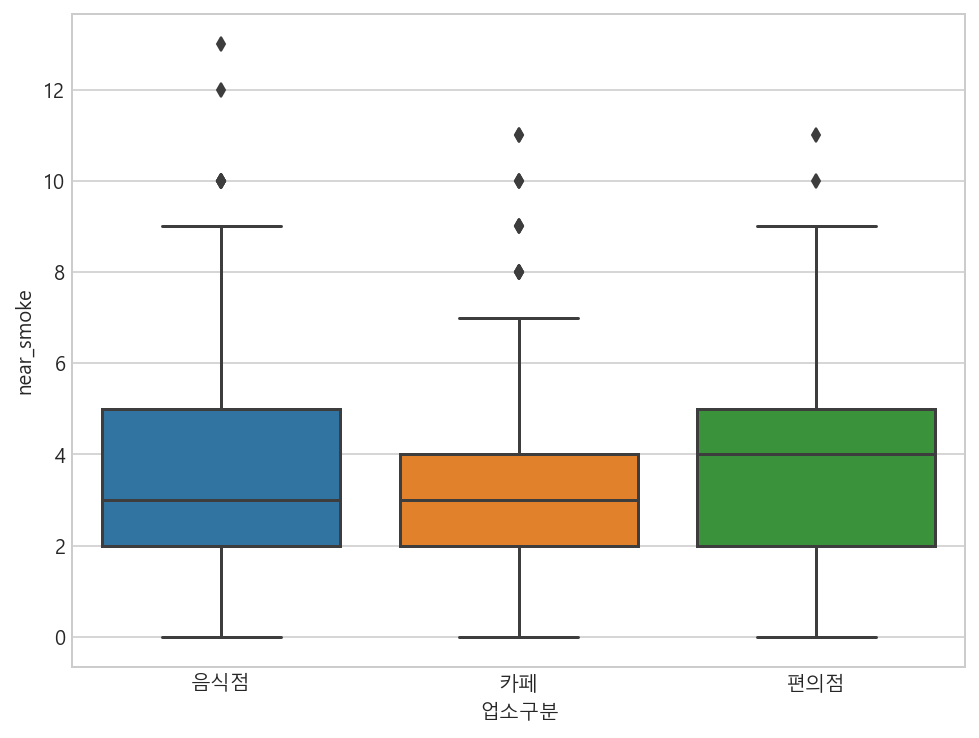

In [32]:
# 업소구분 별 데이터 분포를 boxplot으로 확인
plt.figure(figsize=(8,6))
sns.boxplot(data=restaurant_df, x='업소구분', y='near_smoke')
plt.savefig('boxplot.png')

음식점과 편의점의 분포는 크게 차이가 없었고,  
카페의 경우 평균값이나 전체적인 값의 분포가 낮은 수치였지만 크게 차이가 나지 않았다.  
따라서 업소구분별로 나누는 것은 의미가 크게 있지 않다고 판단했다.

#### 2) 역삼동의 고도 별 면적 데이터

In [33]:
# 역삼동 내의 지형 고도 별 전체 면적을 Contour Map Creator를 이용하여 구하고
# 그것을 csv파일로 저장하여 데이터프레임으로 생성했다.
altitude_df = pd.read_csv('./강남구_역삼동_고도별_면적.csv')
altitude_df

,NO,등고선고도(M),원면적(㎡),실면적(㎡)
0,1,56,14810,14810
1,2,50,73656,58846
2,4,43,543785,470129
3,5,37,1069330,525545
4,6,31,1582385,513055
5,7,25,2378351,795966
6,8,18,3166904,788553
7,9,10,3359778,192874


## 3. 데이터 분석과정
### 3.1 음식점과 흡연구역의 관계

##### a. folium을 이용한 지도 시각화

In [34]:
# 흡연구역 위치를 표시할 부분의 설정
smoke_map = folium.Map(
    location=[37.5020248, 127.0385429],
    zoom_start=15)
for (index, data) in yssmoke_df.iterrows():
    folium.Circle(
        location=[data['lat'], data['long']],
        radius=7,
        color='#3186cc', fill_color='#3186cc'
    ).add_to(smoke_map)
smoke_map

In [35]:
# 히트맵 + 마커 코드_전체
# 관련 패키지 / 모듈 가져 오기
from folium.plugins import HeatMap
# 위치 데이터를 포함하는 csv 파일에서 읽음
data = pd.read_csv("역삼동_211228_최종.csv")
data2 = pd.read_csv("강남구_역삼동_일반&휴게음식점_위도&경도_리얼최종.csv")

# data2에서 업소구분별로 편의점, 카페, 음식점을 다음과 같이 구분할 수 있다.
# data2 = data2[data2['업소구분'] == '편의점']
# 위 코드를 추가하면 편의점의 데이터만 불러올 수 있고, 마찬가지로 카페, 음식점도 가능하다.

In [36]:
# 경도와 위도 값을 추출하여 목록을 분리
lats = data["lat"]
longs = data["long"]

# Map ()을 사용하여 기본 맵 객체 생성
mapObj = folium.Map(location=[37.50411502410576, 127.04054520472388], zoom_start = 15)

# 히트 맵 레이어 생성
heatmap = HeatMap(list(zip(lats, longs)),
                   min_opacity=0.2,
                   radius=30, blur=20,
                   max_zoom=1)

In [37]:
# 업소구분 별로 컬러를 다르게 하기 위한 함수 생성
def marker_color(data2):
    store = data2['업소구분']
    if store == '편의점':
        return 'red'
    elif store == '카페' :
        return 'blue'
    else :
        return 'black'

In [38]:
# 음식점의 위치를 표시할 부분의 설정
for (index, data2) in data2.iterrows():
    folium.Circle(
        location=[data2['LAT'], data2['LONG']],
        radius=data2['MarkerSize'],
        color=marker_color(data2), fill_color=marker_color(data2)
    ).add_to(mapObj)

In [39]:
# 기본지도에 히트 맵 레이어 추가
heatmap.add_to(mapObj)
mapObj
# 히트맵 지도 저장
# mapObj.save('gangnam_tobac_heatmap_1228_total.html')

흡연구역이 밀집되어 있을수록 붉은색으로 표기되는데,  
음식점이 많은 곳 일수록 흡연구역이 밀집되었음을 히트맵을 통해 직관적으로 알 수 있다.

##### b. 초밀집 흡연구역 찾기
음식점 주변의 흡연구역 수를 'near_smoke' 컬럼에 저장했었다.  
이 숫자가 많으면 많을수록 해당 음식점 주변에는 담배에 더 쉽게 노출된다고 볼 수 있는데,  
음식점 당 평균 흡연구역 수인 3.5보다 높은 4개, 그리고 그 두배인 7개인 음식점들을 찾아서 초밀집구역을 재정의 해본다.

In [40]:
# 음식점에서 40m 안에 있는 흡연 구역 개수가 4와 7 이상인 데이터만 불러서 별로도 저장
over4_df = restaurant_df[restaurant_df['near_smoke'] >= 4]
over7_df = restaurant_df[restaurant_df['near_smoke'] >= 7]

In [41]:
# 주변 흡연구역 수가 4개 이상인 음식점
smoke_map = folium.Map(
    location=[37.5020248, 127.0385429],
    zoom_start=15)
for (index, data) in over4_df.iterrows():
    folium.Circle(
        location=[data['LAT'], data['LONG']],
        radius=7,
        color='#3186cc', fill_color='#3186cc'
    ).add_to(smoke_map)
smoke_map
# smoke_map.save('smoking_over4_map.html')

In [42]:
# 주변 흡연구역 수가 7개 이상인 음식점
smoke_map = folium.Map(
    location=[37.5020248, 127.0385429],
    zoom_start=15)
for (index, data) in over7_df.iterrows():
    folium.Circle(
        location=[data['LAT'], data['LONG']],
        radius=7,
        color='#3186cc', fill_color='#3186cc'
    ).add_to(smoke_map)
smoke_map
# smoke_map.save('smoking_over7_map.html')

1. 4개 이상인 구역은 생각보다 많았다. 하지만 특정 구역으로 뭉쳐져 있는 경향이 있으므로 이런 곳에 최소한 꽁초를 버릴 수 있는 시설이 있으면 환경적으로나 시각적으로 조금 더 낫지 않을까 하는 생각이 들었다.  
  
2. 7개 이상인 구역은 직관적으로 보아도 구역이 나눠져서 나타났다. 이런 구역을 초밀집 흡연구역으로 정의하고 흡연시설 설치를 주장하는 것이 좋아보인다.

### 3.2 고도와 흡연구역의 관계

범주형으로 구분값을 설정했으니 이제 각 범주에서 흡연 데이터가 몇 개씩 있는지 확인해보자.  
흡연 데이터에서 고도를 구분값으로 나눈 컬럼에서 value_counts()로 그 수를 확인한다.

In [43]:
# 각 고도별 흡연구역 수를 담기 위한 컬럼 생성
altitude_df['흡연구역 수'] = 0

# 각 고도에 맞는 위치 데이터를 카운트해서 위에 생성한 컬럼에 저장하여 그 수를 확인한다.
for (i, altitude) in altitude_df.iterrows():
    for  (j, smoke) in yssmoke_df['altitude_gubun'].value_counts().iteritems():
        if altitude['등고선고도(M)'] == j :
            altitude_df['흡연구역 수'][i] = smoke
            
# 범위를 10000㎡로 통일 했을 때 흡연구역 수를 확인해보기 위한 계산
altitude_df['10000㎡당 흡연구역 수'] = round(altitude_df['흡연구역 수']
                                          / altitude_df['실면적(㎡)'] * 10000, 3)
altitude_df.sort_values('등고선고도(M)')


,NO,등고선고도(M),원면적(㎡),실면적(㎡),흡연구역 수,10000㎡당 흡연구역 수
7,9,10,3359778,192874,91,4.718
6,8,18,3166904,788553,428,5.428
5,7,25,2378351,795966,305,3.832
4,6,31,1582385,513055,208,4.054
3,5,37,1069330,525545,238,4.529
2,4,43,543785,470129,221,4.701
1,2,50,73656,58846,24,4.078
0,1,56,14810,14810,4,2.701


각 고도를 동일한 면적으로 만들어서 흡연구역 수를 계산하면  
가장 높은 56m에서만 낮은 수치가 나오고,  
나머지 높이에서는 비슷한 수치로 나온다.  
**따라서 고도가 달라진다고 흡연구역의 수가 특별하게 달라지지는 않는다고 해석할 수 있다.**

### 3.3 지하철 역과 흡연구역의 관계

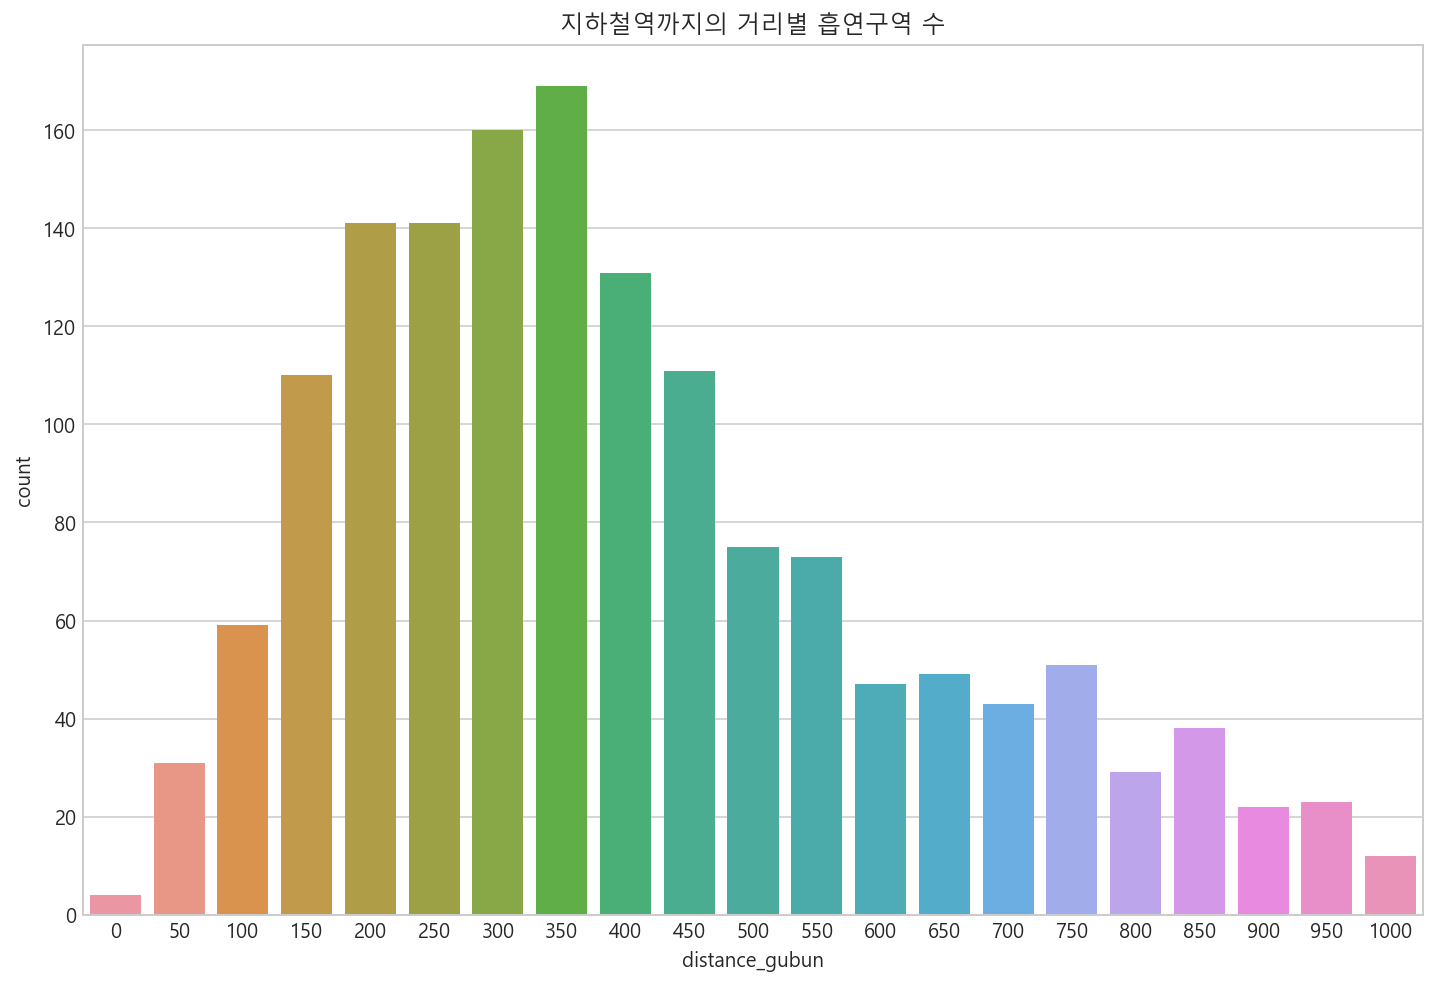

In [44]:
plt.figure(figsize=(12,8))
q = sns.countplot(data=yssmoke_df, x= 'distance_gubun')
q.set_title("지하철역까지의 거리별 흡연구역 수")
plt.show()

지하철 역과의 거리가 300~400m 사이에 있는 구간에 흡연 구역이 많음을 알 수 있지만  
이 그래프로만 봐서는 특별한 인사이트가 나오지 않았다.  
따라서 다른 위치데이터인 음식점과 지하철과의 거리를 계산하여 보았다.

In [45]:
# 음식점 데이터프레임에서 역 이름과 거리를 넣을 컬럼을 생성
restaurant_df['station'] = ''
restaurant_df['distance'] = 0.0
# find_station 함수를 통해 모든 위치 데이터를 for문으로 돌리면서 가까운 역과 그 거리를 부르고
# 데이터프레임에 새로운 컬럼에 저장한다.
for i in range(len(restaurant_df)):
    temp_list = []
    temp_list = find_station((restaurant_df.iloc[i][3],restaurant_df.iloc[i][4]))
    restaurant_df['station'][i] = temp_list[0]
    restaurant_df['distance'][i] = temp_list[1]

In [46]:
restaurant_df

,업종명,업소명,도로명주소,LAT,LONG,MarkerSize,업소구분,near_smoke,station,distance
0,일반음식점,트리아관광호텔,서울특별시 강남구 테헤란로33길 16,37.502870,127.039400,5,음식점,2,역삼역,361.78
1,일반음식점,스매쉬 치즈버거,서울특별시 강남구 강남대로94길 89,37.500980,127.034390,5,음식점,6,역삼역,181.39
2,일반음식점,밥사부 도시락,서울특별시 강남구 강남대로84길 26,37.496940,127.030760,5,음식점,4,강남역,295.02
3,일반음식점,전주현대옥,서울특별시 강남구 역삼로 113,37.493790,127.031480,5,음식점,4,강남역,571.41
4,일반음식점,쿠잉(COOING),서울특별시 강남구 언주로81길 6,37.500360,127.043060,5,음식점,5,역삼역,588.10
...,...,...,...,...,...,...,...,...,...,...
1392,휴게음식점,세븐일레븐 역삼14호점,서울 강남구 논현로105길 53,37.505217,127.030000,5,편의점,5,언주역,411.65
1393,휴게음식점,GS25 강남헤븐리치점,서울 강남구 봉은사로 170,37.506725,127.032662,5,편의점,4,언주역,123.45
1394,휴게음식점,세븐일레븐 역삼10호점,서울 강남구 테헤란로19길 10,37.500707,127.033709,5,편의점,4,역삼역,237.79
1395,휴게음식점,GS25 지에스강남점,서울 강남구 논현로 508,37.502057,127.036476,5,편의점,0,역삼역,156.74


In [47]:
# 마찬가지로 거리를 50m로 범주화하여 데이터를 넣는다.
restaurant_df['distance_gubun'] = 0
restaurant_df['distance_gubun'].loc[restaurant_df['distance'] < 50] = 0
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 50) & (restaurant_df['distance'] < 100)] = 50
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 100) & (restaurant_df['distance'] < 150)] = 100
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 150) & (restaurant_df['distance'] < 200)] = 150
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 200) & (restaurant_df['distance'] < 250)] = 200
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 250) & (restaurant_df['distance'] < 300)] = 250
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 300) & (restaurant_df['distance'] < 350)] = 300
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 350) & (restaurant_df['distance'] < 400)] = 350
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 400) & (restaurant_df['distance'] < 450)] = 400
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 450) & (restaurant_df['distance'] < 500)] = 450
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 500) & (restaurant_df['distance'] < 550)] = 500
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 550) & (restaurant_df['distance'] < 600)] = 550
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 600) & (restaurant_df['distance'] < 650)] = 600
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 650) & (restaurant_df['distance'] < 700)] = 650
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 700) & (restaurant_df['distance'] < 750)] = 700
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 750) & (restaurant_df['distance'] < 800)] = 750
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 800) & (restaurant_df['distance'] < 850)] = 800
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 850) & (restaurant_df['distance'] < 900)] = 850
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 900) & (restaurant_df['distance'] < 950)] = 900
restaurant_df['distance_gubun'].loc[(restaurant_df['distance'] >= 950) & (restaurant_df['distance'] < 1000)] = 950
restaurant_df['distance_gubun'].loc[restaurant_df['distance'] >= 1000] = 1000
restaurant_df

,업종명,업소명,도로명주소,LAT,LONG,MarkerSize,업소구분,near_smoke,station,distance,distance_gubun
0,일반음식점,트리아관광호텔,서울특별시 강남구 테헤란로33길 16,37.502870,127.039400,5,음식점,2,역삼역,361.78,350
1,일반음식점,스매쉬 치즈버거,서울특별시 강남구 강남대로94길 89,37.500980,127.034390,5,음식점,6,역삼역,181.39,150
2,일반음식점,밥사부 도시락,서울특별시 강남구 강남대로84길 26,37.496940,127.030760,5,음식점,4,강남역,295.02,250
3,일반음식점,전주현대옥,서울특별시 강남구 역삼로 113,37.493790,127.031480,5,음식점,4,강남역,571.41,550
4,일반음식점,쿠잉(COOING),서울특별시 강남구 언주로81길 6,37.500360,127.043060,5,음식점,5,역삼역,588.10,550
...,...,...,...,...,...,...,...,...,...,...,...
1392,휴게음식점,세븐일레븐 역삼14호점,서울 강남구 논현로105길 53,37.505217,127.030000,5,편의점,5,언주역,411.65,400
1393,휴게음식점,GS25 강남헤븐리치점,서울 강남구 봉은사로 170,37.506725,127.032662,5,편의점,4,언주역,123.45,100
1394,휴게음식점,세븐일레븐 역삼10호점,서울 강남구 테헤란로19길 10,37.500707,127.033709,5,편의점,4,역삼역,237.79,200
1395,휴게음식점,GS25 지에스강남점,서울 강남구 논현로 508,37.502057,127.036476,5,편의점,0,역삼역,156.74,150


In [48]:
# 흡연구역과 지하철 역을 a, 음식점과 지하철 역을 b로 놓고 각 거리별 숫자를 담은 데이터프레임을 만든다
a = yssmoke_df.groupby('distance_gubun').count()
b = restaurant_df.groupby('distance_gubun').count()

<AxesSubplot:xlabel='distance_gubun', ylabel='distance'>

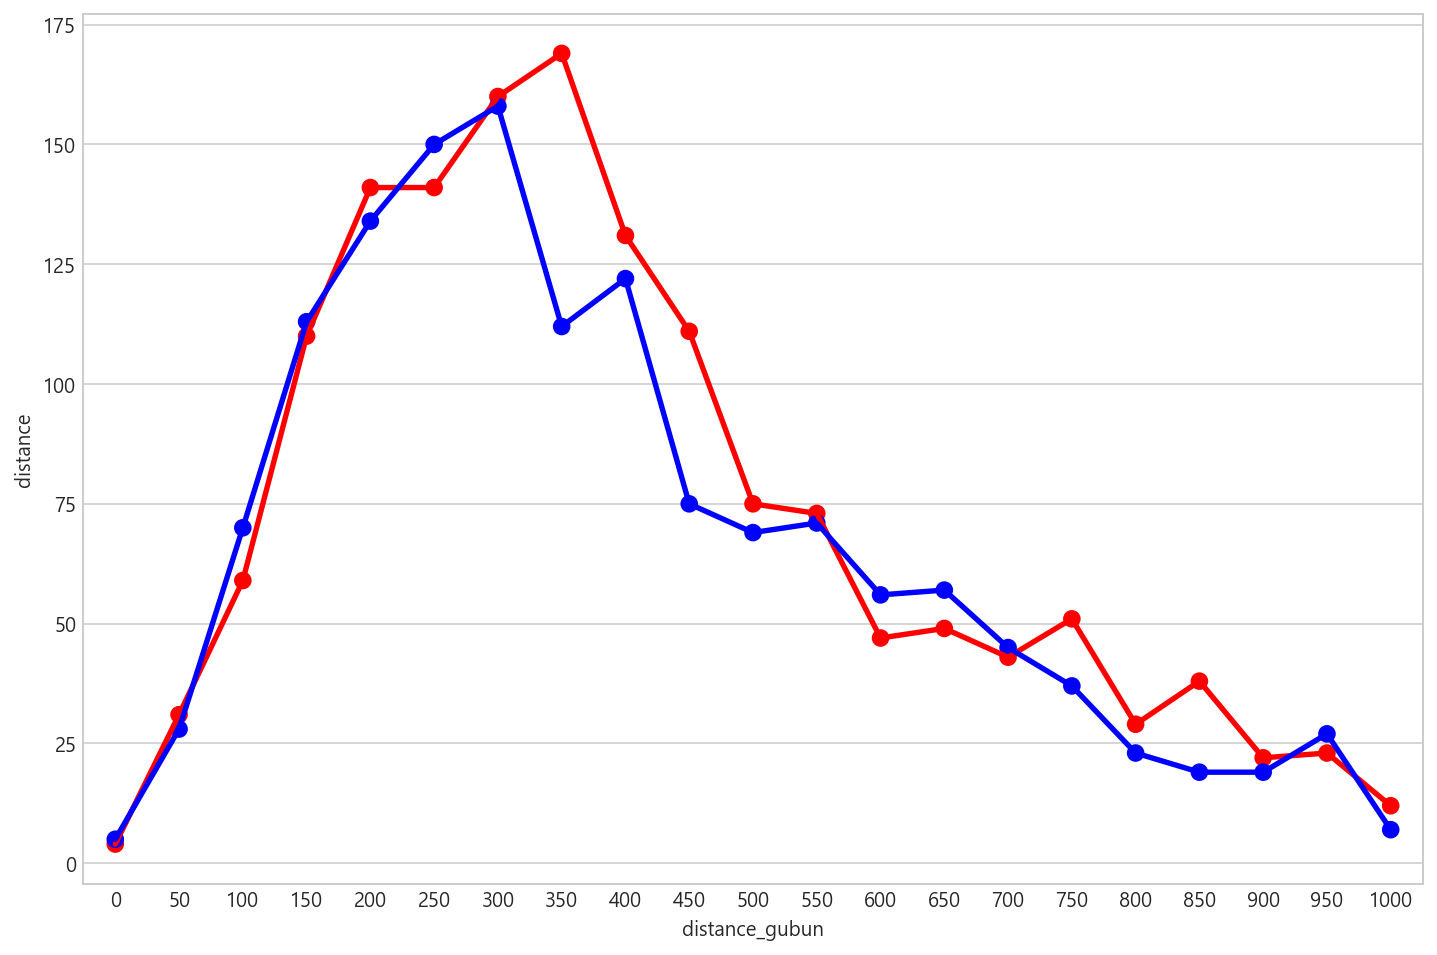

In [49]:
# a, b를 꺽은선 그래프로 비교하여 본다.
plt.figure(figsize=(12,8))
sns.pointplot(data=a, x= a.index, y='distance', color='r' )
sns.pointplot(data=b, x= b.index, y='distance', color='b')


빨간색은 흡연구역-지하철, 파란색은 음식점-지하철의 거리 별 개수이다.  
두 그래프가 비슷하게 움직인다는 것은 흡연구역은 지하철의 거리와 관계가 있다기보다  
오히려 음식점과의 연관성이 더 있다고 설명할 수 있다.